In [6]:
import nest_asyncio
nest_asyncio.apply()
import cmdstanpy as sp
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
import matplotlib.patches as mpatches
import seaborn as sns
import scipy.stats as stats
plt.rcParams["xtick.minor.visible"] =  True
plt.rcParams["ytick.minor.visible"] =  True
plt.rcParams["mathtext.fontset"]="cm"
plt.rcParams['errorbar.capsize'] = 3
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=8
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle']=':'
plt.rcParams['grid.color']='black'
plt.rcParams['axes.prop_cycle'] = cycler(color=['black', 'red', 'blue', 'green'])

import arviz as az
import warnings
warnings.filterwarnings('ignore')

In [56]:
#generate data
def true_f(x):
    return 1*np.cos(x)+1
def f(x,a,b):
    return a*np.cos(x)+b

In [64]:
#generate data
x=np.linspace(0,10,15)
y=true_f(x)
dy=np.random.normal(0.25,0.05,len(y))
noise=np.random.normal(0,dy,len(y))
y+=noise
df=pd.DataFrame(data={'x':x,'y':y,'dy':dy})
df.to_csv('./noisy_data.csv',index=False)



In [65]:
noisy_data=pd.read_csv('noisy_data.csv')

In [77]:
popt, pcov = curve_fit(f,noisy_data['x'].values,noisy_data['y'].values,
    sigma=noisy_data['dy'].values)
chisq=0
for i in range(len(noisy_data['x'].values)):
    chisq+=(f(x[i],*popt)-y[i])**2/dy[i]**2
print(chisq/(15-2))

1.3917923372465486


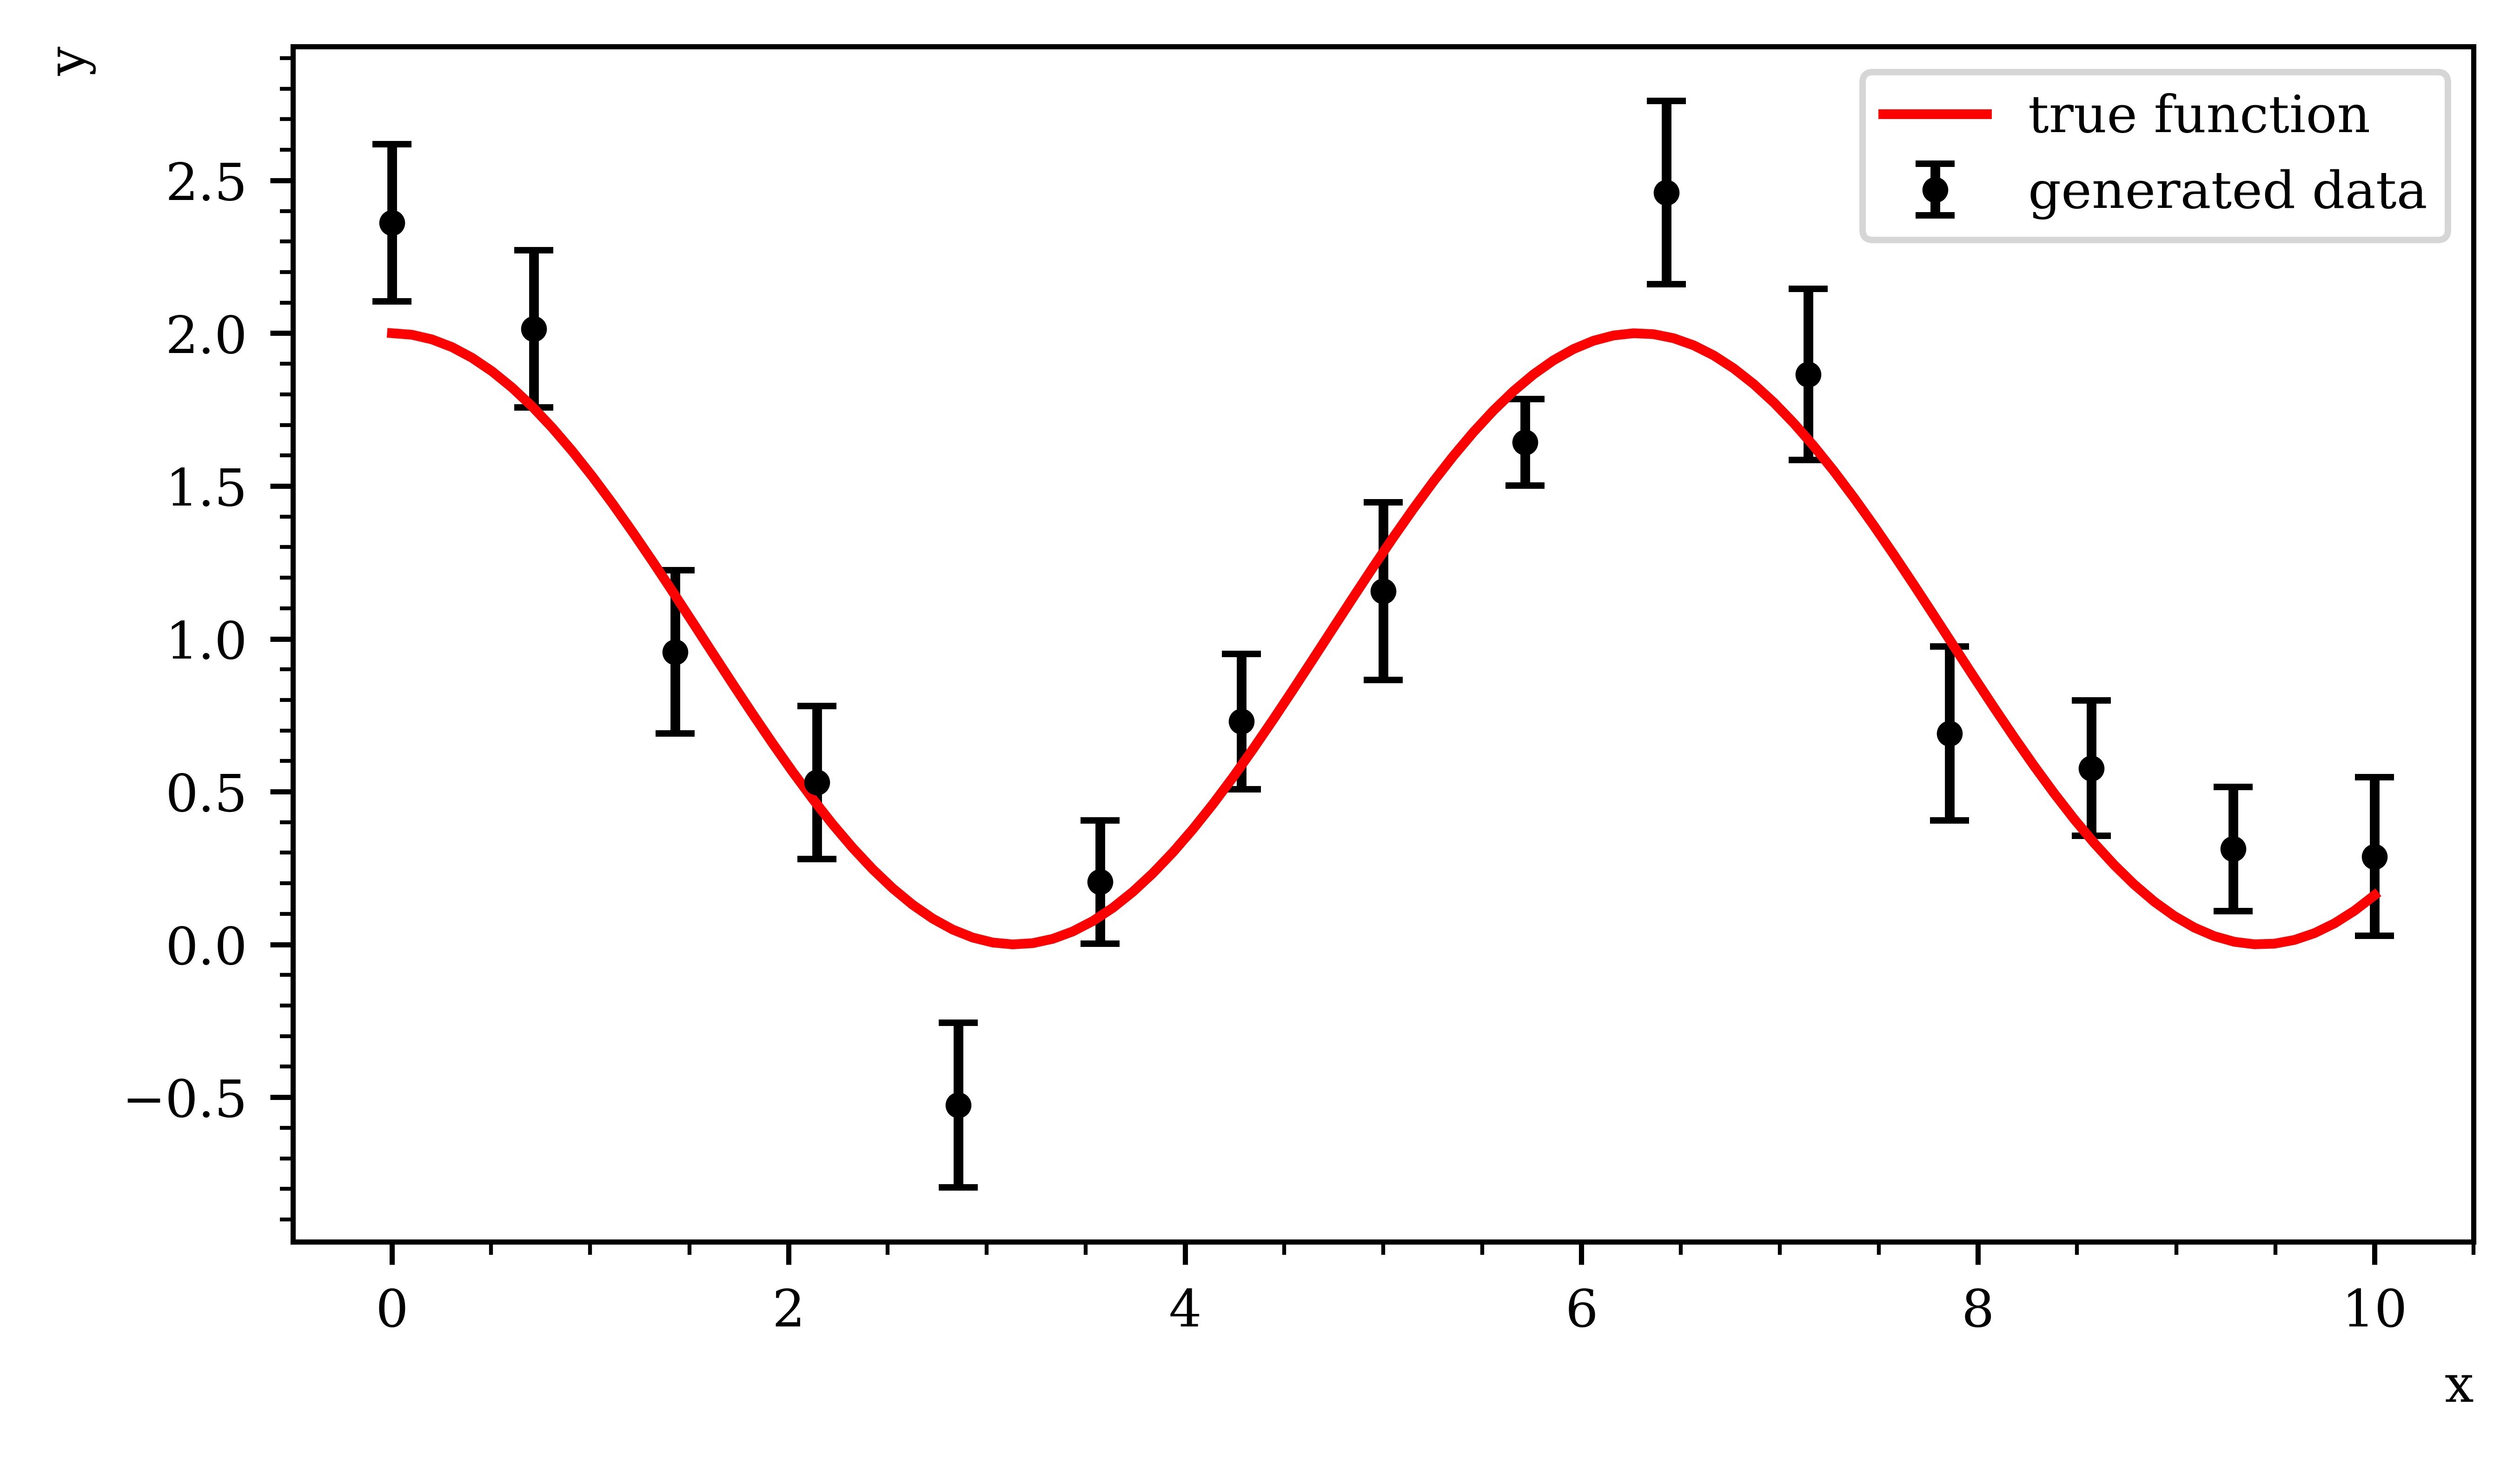

In [66]:
fig, ax = plt.subplots(figsize=([15.3728/2.54,8.6472/2.54]),dpi=1000)
ax.errorbar(x=noisy_data['x'],y=noisy_data['y'],yerr=noisy_data['dy'],fmt='.',label='generated data')
ax.grid(False)
ax.plot(np.linspace(0,10,100),true_f(np.linspace(0,10,100)),label='true function')
ax.set_xlabel('x',horizontalalignment='right',x=1.0)
ax.set_ylabel('y',horizontalalignment='right',y=1.0)
fig.savefig('./data.pdf')
plt.legend()



In [81]:
class bayesian_fit():
    def __init__(self,data,stanfile,nsamples=1000):
        self.data=data
        self.stan_data={'n':len(self.data['x'].values),
             'x':list(self.data['x'].values),
             'y':list(self.data['y'].values),
           'dy':list(self.data['dy'].values)}
        self.stanfile=stanfile
        self.x=self.data['x']
        self.y=self.data['y']
        self.dy=self.data['dy']
        self.model = sp.CmdStanModel(stan_file=stanfile)
        self.fitobj = self.model.sample(data=self.stan_data,iter_sampling=nsamples,output_dir='./csv_files')
    #funtion w/o phase
    def f(self,x,a,b):
            return a*np.cos(x)+b
    #function with phase
    def f1(self,x,a,b,c):
            return a*np.cos(x+c)+b
    #chi2 parameters of fitted data
    def get_chisqpars(self,function):
            popt, pcov = curve_fit(function,self.data['x'].values,self.data['y'].values,
                                   sigma=self.data['dy'].values)
            return popt,pcov
    #print stan code
    def stan_code(self):
        return self.model.code()
    #get pd dataframe of samples
    def samples_df(self):
        return self.fitobj.draws_pd()
    #calculate waic for given samples and log likelihoods
    def waic(self):
        samples=self.fitobj.draws_pd()
        pwaic=np.array([np.var(samples[f'log_lik[{i+1}]'], ddof=1)for i in range(len(self.data['x']))])
        lpd=np.array([np.log(np.mean(np.exp(samples[f'log_lik[{i+1}]'])))for i in range(len(self.data['x']))])
        elpd=lpd-pwaic
        se=np.sqrt(len(self.x)*np.var(elpd,ddof=1))
        return sum(elpd), se, elpd
    #plot posterior predictive distributions
    def plot_ppd(self,save,fitfunc,width=.5):
        samples=self.fitobj.draws_pd()
        #cosmetics
        fig, (ax, ax1)=plt.subplots(nrows=2,sharex=True,figsize=([15.3728/2.54,8.6472/2.54]),dpi=1000,gridspec_kw={'height_ratios': [4, 1]})
        ax.set_ylabel('$p(y_{rep}|y)$')
        ax.xaxis.set_ticks_position("top")
        ax.grid(False)
        #get results from chisq fit and plot them
        xx=np.linspace(np.min(self.data['x']),np.max(self.data['x']),200)
        params=self.get_chisqpars(fitfunc)[0]
        yfit=fitfunc(xx,*params)
        ax.errorbar(x=self.data['x'],y=self.data['y'],yerr=self.data['dy'],fmt='.',label='Data points',color='darkorange')
        #ax.plot(data['x'],data['y'],'x',label='Data points')
        ax.plot(xx,yfit,'r-',label='$\chi^2$ fit',color='darkorange')
        #violinplot for the replicated samples
        vp=ax.violinplot([samples[f'y_tilde[{i+1}]']for i in range(len(self.data['x']))],np.array(self.x),
                         showmeans=False, showextrema=False, showmedians=False,widths=width)
        #cosmetics
        for b in vp['bodies']:
            # get the center
            m = np.mean(b.get_paths()[0].vertices[:, 0])
            # modify the paths to not go further right than the center
            b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
            b.set_alpha(.5)
            b.set_color('midnightblue')

        #compute p value as measure of goodness of fit
        y_arr=[samples[f'y_tilde[{i+1}]']for i in range(len(self.data['x']))]
        pvalue=[len([y for y in y_arr[i] if y>=self.data['y'][i]])/len(y_arr[i])for i in range(len(self.data['x']))]
        #plot pvalue
        #ax1.grid(which='minor',color='grey',lw='.4')
        ax1.plot(self.data['x'],pvalue,'.')
        ax1.axhline(y=0.5, color='darkorange', linestyle='--',label='optimal value')
        ax1.set_xlabel('x')
        ax1.set_ylabel('$T(y_{rep}>y)$')
        ax1.set_ylim([0,1])
        ax1.grid(False)
        #cosmetics and legend
        plt.subplots_adjust(wspace=0, hspace=0)
        lines,labels = ax.get_legend_handles_labels() 
        patch = mpatches.Patch(color='midnightblue', label='$y_{rep}$',alpha=.5)
        lines.append(patch)
        lines1,labels1=ax1.get_legend_handles_labels()
        lines+=lines1
        tmp=lines[0]
        lines[0]=lines[1]
        lines[1]=tmp
        plt.legend(handles=lines,bbox_to_anchor=(1,2))
        if (save==True):
            plt.savefig(f'./ppd_{len(params)}_params.pdf',format='pdf',bbox_inches='tight',dpi=1000)
    # plot posterior distributions of desired parameters, indicate chi2 fit value(s) and error(s)
    def plot_posterior(self,params,func,save=False):
        samples=self.fitobj.draws_pd()
        chi2pars=self.get_chisqpars(function=func)
        fig, (ax)=plt.subplots(ncols=1,nrows=len(params),figsize=([15.3728/2.54,8.6472/2.54]),dpi=1000)
        #print(len(params))
        for i in range(len(params)):
            #cosmetics
            ax[i].grid(False)
            ax[i].tick_params(axis='both',which='both',direction='in')
            ax[i].set_ylabel('Frequency',fontsize=8,horizontalalignment='right',y=1.0)
            ax[i].tick_params(axis='y', which='both',left=False,right=False,labelleft=False)
            ax[i].tick_params(axis='x', which='both',labelsize=8)
            #plot data
            ax[i].errorbar(x=chi2pars[0][i],y=0,xerr=np.sqrt(chi2pars[1][i,i]),label='$\chi^2$-fit',color='blue')
            #plot posterior kde distribution bc pretty
            sns.distplot(samples[params[i]],hist=True,kde=True,ax=ax[i],kde_kws={'bw':0.35})
                        
            ax[i].set_xlabel(f'$\\theta_{i+1}$',fontsize=8,horizontalalignment='right',x=1.0)


            kde_curve = ax[i].lines[0]
            x = np.array(kde_curve.get_xdata())
            y = np.array(kde_curve.get_ydata())
            maxpos = y.argmax()
            maxx=x[maxpos]
            counts, bins = np.histogram(samples[params[i]],bins=20)
            mean=np.mean(samples[params[i]])
            sd=np.std(samples[params[i]])
            #mids = 0.5*(bins[1:] + bins[:-1])
            #probs = counts / np.sum(counts)
    
            #mean = np.sum(probs * mids)  
            #sd = np.sqrt(np.sum(probs * (mids - mean)**2))
            #indicate chi2 values
            ax[i].axvline(x=maxx,ymin=0,ymax=1,linewidth='.5',label='MPV',color='red')
            ax[i].axvline(x=mean,ymin=0,ymax=1,linewidth='.5',label='$\mu\pm 1\sigma$',color='red',linestyle='dashed')
            ax[i].axvline(x=mean-sd,ymin=0,ymax=1,linewidth='.5',color='red',linestyle='dashed')
            ax[i].axvline(x=mean+sd,ymin=0,ymax=1,linewidth='.5',color='red',linestyle='dashed')
            #cosmetics and legend
            #plt.legend(bbox_to_anchor=(1,2),fontsize=10)
            plt.subplots_adjust(hspace=0.5)
        if(save):
            fig.savefig(f'./posterior_{len(params)}_params.pdf',format='pdf',dpi=1000)

    # function to plot the posterior distributions as is     
    def plot_trace(self,params,save=False):
        samples=self.fitobj.draws_pd()
        fig, (ax)=plt.subplots(ncols=2,nrows=len(params),dpi=1000)
        #print(ax.shape)
        ls=['solid','dotted','dashed','dashdot']
        for i in range(len(params)):
            ax[i][0].grid(visible=False,axis='y')
            ax[i][0].set_xlabel(params[i],fontsize=10)
            ax[i][0].set_ylabel('Frequency',fontsize=10)
            ax[i][1].set_xlabel('iteration',fontsize=10)
            ax[i][1].set_ylabel(params[i],fontsize=10)
            for k in range(4):
                sns.kdeplot(samples[params[i]][k*1000:(k+1)*1000],ax=ax[i][0],linestyle=ls[k],color='black',
                            linewidth=.5,bw=0.35)
                ax[i][1].plot(np.arange(0,len(samples[params[i]])/4),
                              samples[params[i]][k*1000:(k+1)*1000],ls=ls[k],color='black',alpha=.7,linewidth=.5)
                for j in (0,1):
                    ax[i][j].tick_params(axis='y', which='both',left=False,right=False,labelleft=False)
                    #ax[i][j].set_title(params[i])
                    ax[i][j].tick_params(axis='both', which='major', labelsize=10)
        plt.subplots_adjust(hspace=1)
        #fig.set_size_inches(8.29,1*len(params))
def find_y_for_x(x, y, value):
    for i in range(len(x)):
        if x[i]<= value and x[i+1]>= value:
            return y[i]
            break
        
#calculate savage dickey density ratio = Bayes factor
def plot_sddr(samples,fixpar,saveas):#this is the model with one parameter more
    fig, ax =plt.subplots(dpi=1000)
    #define prior data and get posterior using kde
    x=np.linspace(-.5,.5,1000)
    def prior(x):
        return stats.norm.pdf(x,0,np.pi)
    priorval=prior(fixpar)
    sns.distplot(samples,hist=True,kde=True,ax=ax,kde_kws={'bw':0.35},label='$p(c|y,M_1)$')
    kde_curve = ax.lines[0]
    xx = kde_curve.get_xdata()
    y = kde_curve.get_ydata()
    postval=find_y_for_x(xx,y,fixpar)
    #plot
    ax.plot(x,prior(x),label='$\pi(c|M_1)$')
    ax.vlines(fixpar,0,np.max(y),linestyle='--',color='peachpuff',label='BF={:.2f}'.format(postval/priorval))
    ax.legend(bbox_to_anchor=(1,1))
    fig.savefig(saveas,format='pdf',dpi=1000,bbox_inches='tight')
def elpd_diff(fit,fit1):
    elpd=np.array(fit.waic()[2])
    elpd1=np.array(fit1.waic()[2])
    return np.abs(sum(elpd)-sum(elpd1)),np.sqrt(len(fit.x)*np.var(elpd-elpd1))

In [82]:
fit=bayesian_fit(data=noisy_data,stanfile='stan_file.stan',nsamples=1000)
#fit1=bayesian_fit(data=noisy_data,stanfile='stan_file1.stan',nsamples=1000)
samples=fit.samples_df()
#samples1=fit1.samples_df()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [83]:
#plot_sddr(samples=samples1['c'],fixpar=0,saveas='./sddr_m0.pdf')

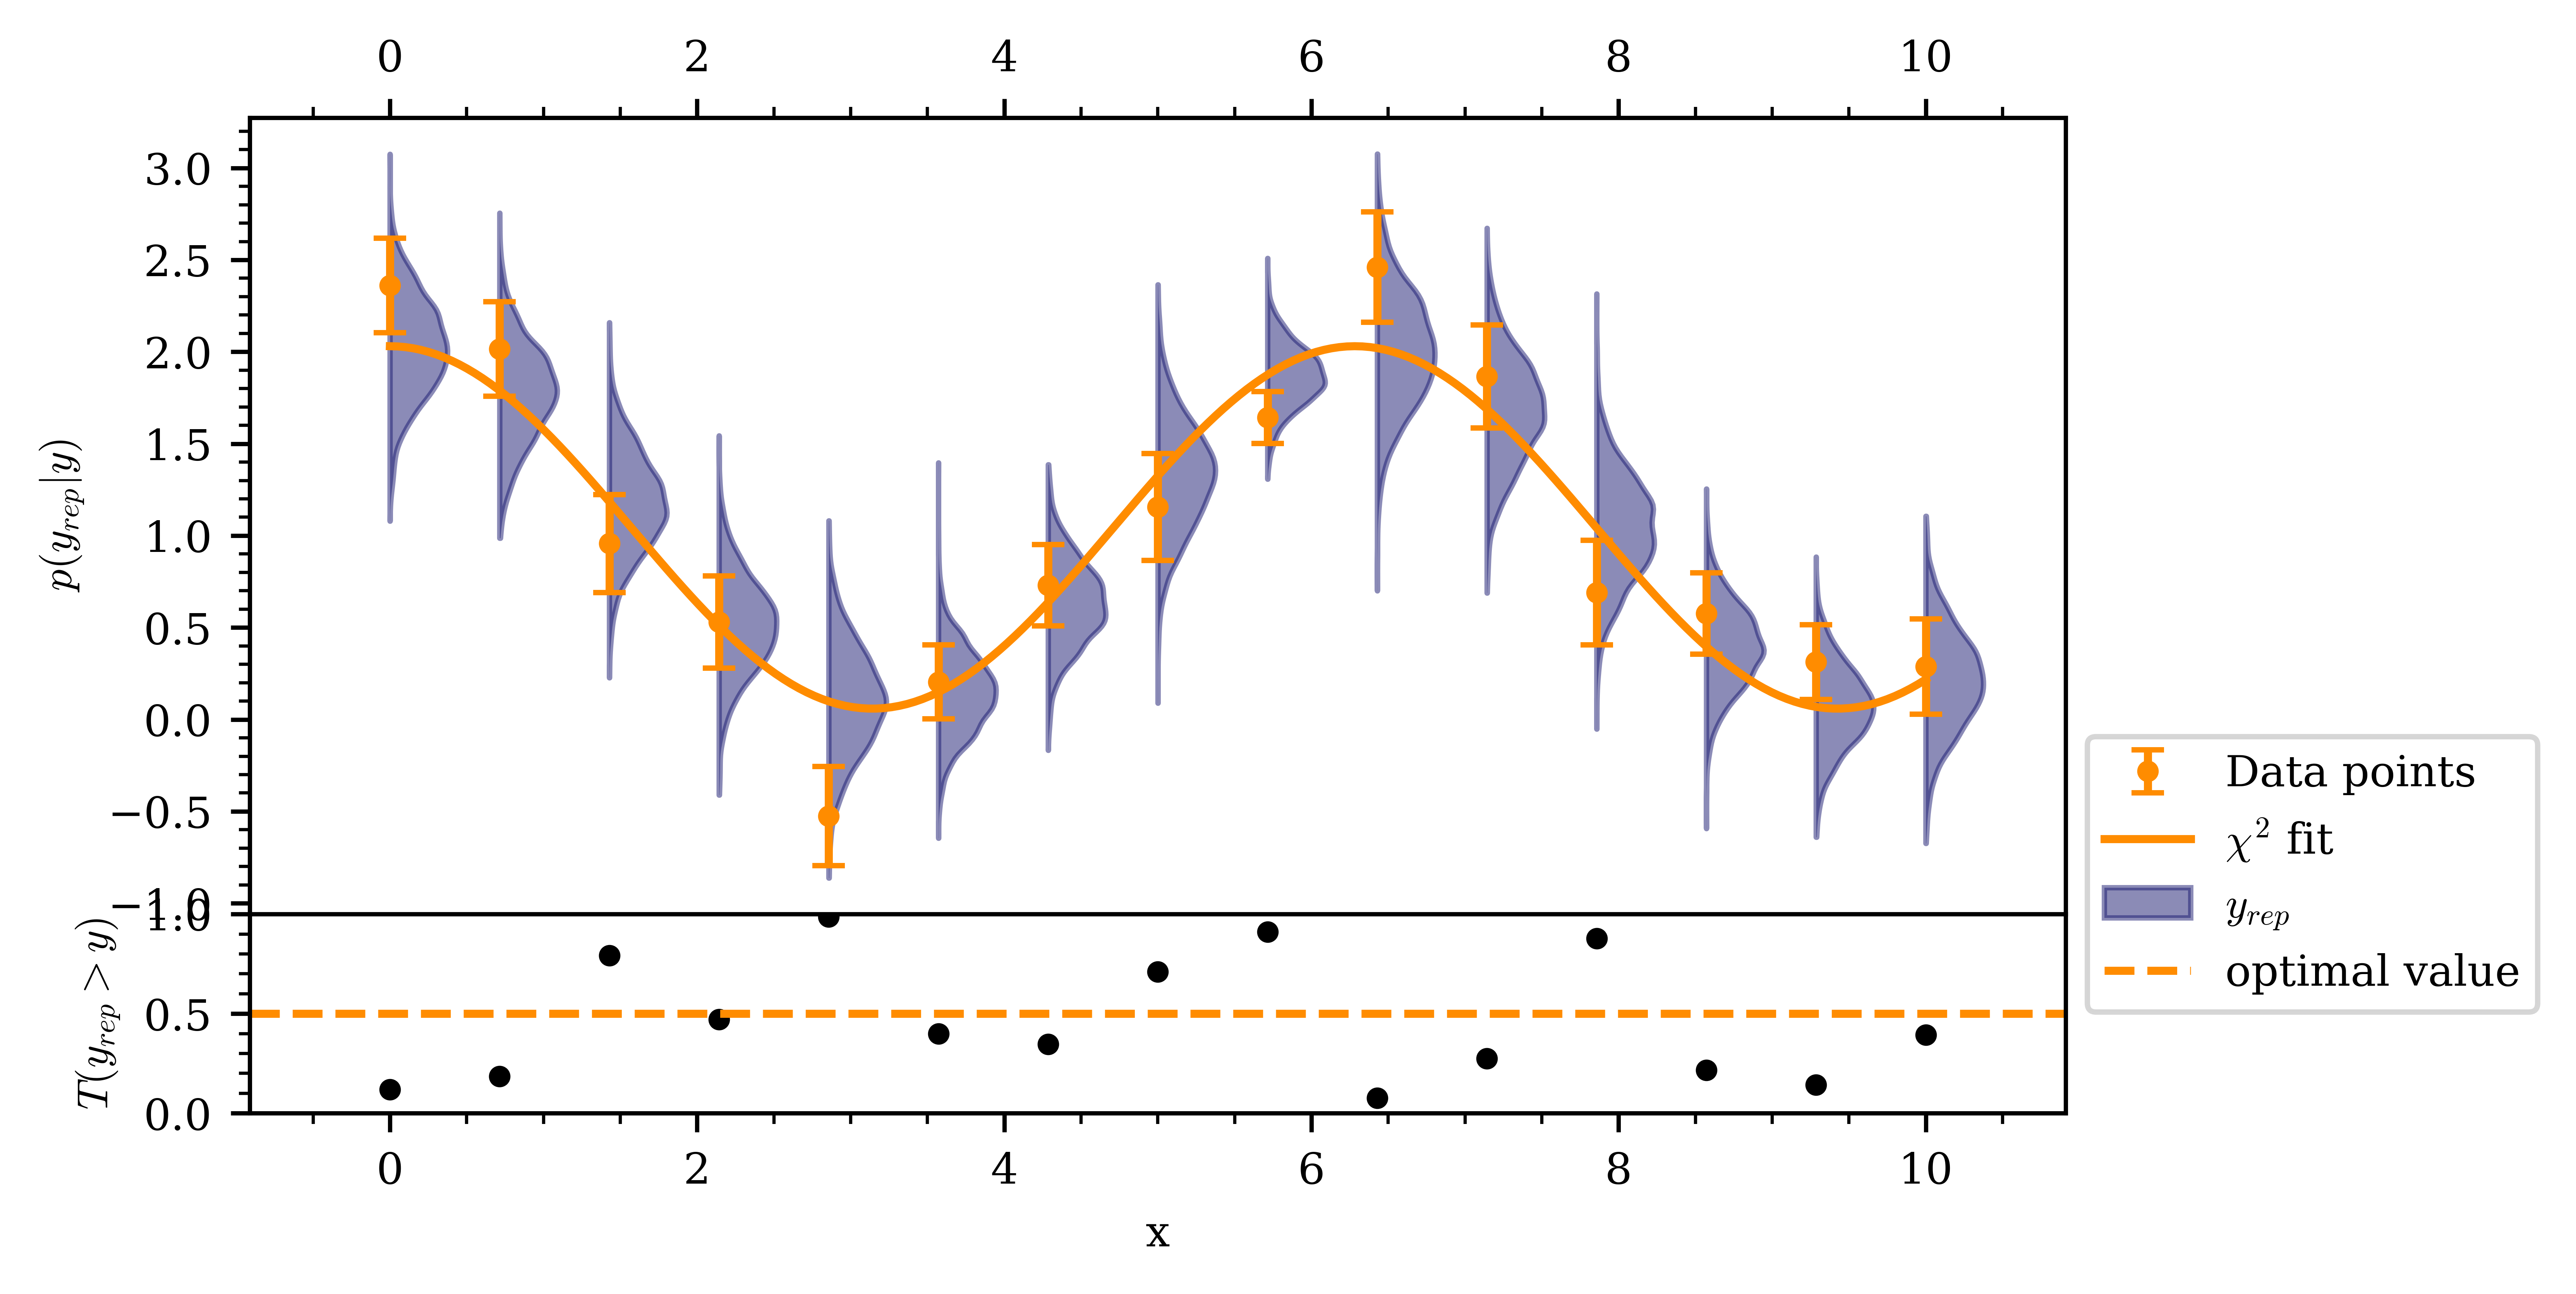

In [85]:
fit.plot_ppd(save=True,fitfunc=fit.f,width=.75)
#fit.plot_posterior(params=['a','b'],func=fit.f1,save=True)

In [87]:
rhat=az.rhat(np.transpose(fit.fitobj.draws(concat_chains=False)[:,:,7]))
print(rhat)


1.0017460438613026


In [51]:
samples

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,a,b,y_tilde[1],...,y_tilde[6],y_tilde[7],y_tilde[8],y_tilde[9],y_tilde[10],y_tilde[11],y_tilde[12],y_tilde[13],y_tilde[14],y_tilde[15]
0,-8.90953,0.823787,0.922965,2.0,3.0,0.0,9.31690,1.038130,0.848158,1.56141,...,-0.250879,0.636456,0.605639,2.18159,1.82353,1.57038,1.186700,0.251461,-0.359691,0.187169
1,-8.27618,1.000000,0.922965,2.0,3.0,0.0,9.78102,0.986056,1.009690,2.24686,...,-0.210889,0.352074,1.317270,1.65669,2.47263,1.83678,0.994072,0.437663,0.014243,0.105609
2,-7.13885,1.000000,0.922965,2.0,3.0,0.0,8.06895,0.928476,0.906745,1.36314,...,0.120822,0.427360,1.315220,1.82251,1.83096,1.52689,0.194488,0.475408,0.027090,0.102769
3,-7.28419,0.963162,0.922965,2.0,3.0,0.0,7.43357,0.878114,0.922675,1.81982,...,-0.244694,0.667617,1.244890,1.52104,1.62622,1.50655,1.004540,0.178326,-0.264594,-0.138927
4,-9.43393,0.741812,0.922965,2.0,3.0,0.0,9.46345,1.098150,0.889707,2.42730,...,0.620670,0.547468,2.044960,1.55847,2.47009,1.81723,0.565759,-0.028920,-0.175793,0.214971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-7.27744,0.998528,0.804032,2.0,3.0,0.0,7.72538,0.914214,0.965769,1.57065,...,0.285624,0.362716,1.019380,1.20633,2.07111,1.65460,0.541540,0.378772,0.041214,0.318182
3996,-7.27744,0.737998,0.804032,2.0,3.0,0.0,9.52123,0.914214,0.965769,1.92712,...,0.048963,0.488996,0.958853,1.79378,2.25182,1.57473,1.149740,0.296228,-0.275774,-0.229200
3997,-7.78890,0.565390,0.804032,3.0,7.0,0.0,13.14090,0.947981,0.860699,1.74788,...,-0.240860,0.167995,0.892625,1.43395,1.50782,1.64518,1.114190,0.162302,-0.198992,0.003842
3998,-7.17674,1.000000,0.804032,2.0,3.0,0.0,7.81885,0.906442,0.908198,1.96814,...,-0.433115,0.967214,0.889220,1.28334,2.21022,1.44449,1.393770,0.633618,-0.280266,0.422943


In [12]:
elpd_diff(fit,fit1)

(0.3573138145709942, 1.482712958918117)

In [13]:
#fit1.plot_posterior(params=['a','b','c'],func=fit1.f1,save=True)
#fit.plot_posterior(params=['a','b'],func=fit.f,save=True)
#fit.get_chisqpars(function=fit.f)
#fit.plot_trace(params=['a','b'])
#fit1.plot_trace(params=['a','b','c'])

In [14]:
a=np.array([i for i in range(50)])
b=np.array([i for i in range(50)])

In [88]:
az.mcse((fit.fitobj.draws(concat_chains=True)[:,7]),method='median')/np.median(samples['a'])

0.0015894606454037539

In [89]:
az.mcse(np.transpose(fit.fitobj.draws(concat_chains=False)[:,:,8]),method='median')/np.median(samples['b'])

0.001298339087700365